In [15]:
from datasets import load_dataset

ds = load_dataset("ethz/food101")

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Using num_workers: 0
Number of training samples: 75750
Number of validation samples: 25250
Number of classes: 101
Attempting to get a sample batch for visualization...
Sample batch image shape: torch.Size([64, 3, 128, 128]), labels shape: torch.Size([64])


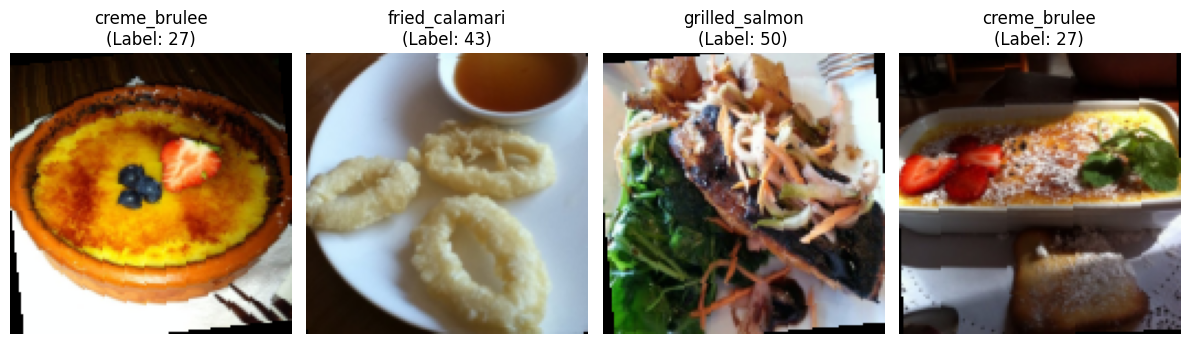

In [ ]:
IMG_SIZE = 128 

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),     
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ds['train']
val_dataset = ds['validation']

def process_batch_train(batch_dict):
   
    transformed_images = [train_transforms(img.convert("RGB")) for img in batch_dict['image']]
    batch_dict['image'] = transformed_images 
    
    return batch_dict 

def process_batch_val(batch_dict):

    transformed_images = [val_transforms(img.convert("RGB")) for img in batch_dict['image']]
    batch_dict['image'] = transformed_images

    return batch_dict

train_dataset.set_transform(process_batch_train)
val_dataset.set_transform(process_batch_val)

def custom_collate_fn(list_of_single_examples):
    if not list_of_single_examples:
        return {'image': torch.empty(0), 'label': torch.empty(0)}

    images = torch.stack([example['image'] for example in list_of_single_examples])
    labels = torch.tensor([example['label'] for example in list_of_single_examples], dtype=torch.long)
    return {'image': images, 'label': labels}

BATCH_SIZE = 64
num_workers = 0 
print(f"Using num_workers: {num_workers}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, num_workers=num_workers)

print(f"Number of training samples: {len(train_dataset)}") 
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of classes: {train_dataset.features['label'].num_classes}")

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


print("Attempting to get a sample batch for visualization...")
sample_batch = next(iter(train_loader))
images = sample_batch['image']
labels = sample_batch['label']
print(f"Sample batch image shape: {images.shape}, labels shape: {labels.shape}")

plt.figure(figsize=(12,5)) 
class_names = train_dataset.features['label'].namesA
for i in range(min(4, len(images))):
    ax = plt.subplot(1, 4, i + 1)
    imshow(images[i])
    plt.title(f"{class_names[labels[i].item()]}\n(Label: {labels[i].item()})")
    plt.axis("off")
plt.tight_layout() 
plt.show()


In [18]:
class FoodCNN(nn.Module):
    def __init__(self, num_classes=101):
        super(FoodCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        flattened_size_dim = IMG_SIZE // 16
        self.flattened_size = 256 * flattened_size_dim * flattened_size_dim
        
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(-1, self.flattened_size) 
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) 
        return x

num_classes = train_dataset.features['label'].num_classes
model = FoodCNN(num_classes=num_classes).to(device)
print(model)


dummy_input = torch.randn(2, 3, IMG_SIZE, IMG_SIZE).to(device) 
output = model(dummy_input)
print(f"\nOutput shape from dummy input: {output.shape}") 

FoodCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=101, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Output shape from dummy input: torch.Size([2, 101])


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [20]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train() 
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad() 

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward() 
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        progress_bar.set_postfix(loss=(running_loss/total_samples), acc=(correct_predictions.double()/total_samples).item())
        
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    return epoch_loss, epoch_acc.item()

def validate_epoch(model, dataloader, criterion, device):
    model.eval() 
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            
            progress_bar.set_postfix(loss=(running_loss/total_samples), acc=(correct_predictions.double()/total_samples).item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    return epoch_loss, epoch_acc.item()

In [21]:
NUM_EPOCHS = 10 

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
        
    print(f"Epoch {epoch+1} Summary: ")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nFinished Training!")



Starting Training...

Epoch 1/10


Training:  20%|█▉        | 236/1184 [03:27<14:00,  1.13it/s, acc=0.0171, loss=4.56]c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 Summary: 
  Train Loss: 4.2740, Train Acc: 0.0532
  Val Loss: 3.8391, Val Acc: 0.1148

Epoch 2/10


Epoch 2 Summary: 
  Train Loss: 3.8377, Train Acc: 0.1157
  Val Loss: 3.4488, Val Acc: 0.1769

Epoch 3/10


Epoch 3 Summary: 
  Train Loss: 3.5866, Train Acc: 0.1601
  Val Loss: 3.2336, Val Acc: 0.2244

Epoch 4/10


Epoch 4 Summary: 
  Train Loss: 3.4095, Train Acc: 0.1921
  Val Loss: 3.0927, Val Acc: 0.2495

Epoch 5/10


Epoch 5 Summary: 
  Train Loss: 3.2903, Train Acc: 0.2131
  Val Loss: 2.9482, Val Acc: 0.2783

Epoch 6/10


Epoch 6 Summary: 
  Train Loss: 3.1852, Train Acc: 0.2316
  Val Loss: 2.9053, Val Acc: 0.2846

Epoch 7/10


Epoch 7 Summary: 
  Train Loss: 3.1039, Train Acc: 0.2490
  Val Loss: 2.8279, Val Acc: 0.3049

Epoch 8/10


Epoch 8 Summary: 
  Train Loss: 3.0375, Train Acc: 0.2622
  Val Loss: 2.8251, Val Acc: 0.3074

Epoch 9/10


Epoch 9 Summary: 
  Train Loss: 2.9831, Train Acc: 0.2732
  Val Loss: 2.8497, Val Acc: 0.3048

Epoch 10/10


Epoch 10 Summary: 
  Train Loss: 2.9298, Train Acc: 0.2859
  Val Loss: 2.7192, Val Acc: 0.3242

Finished Training!


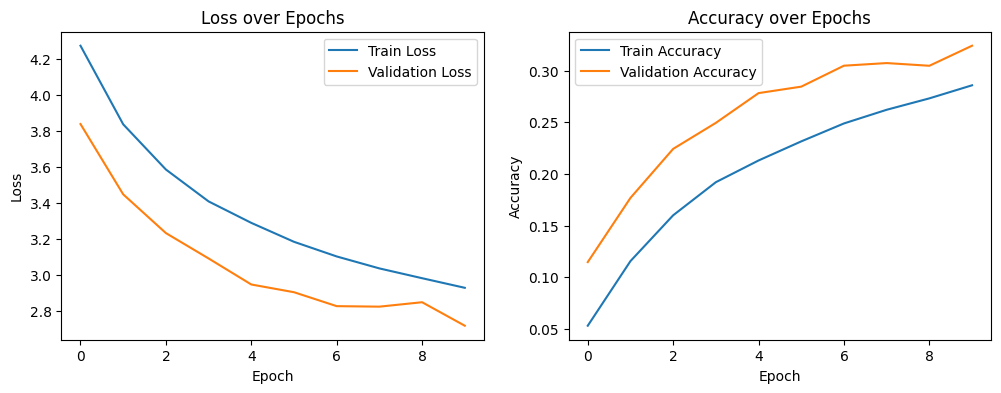

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()